# Домашнее задание. Решение конкурса на kaggle.com

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

## 1) Загрузка данных и первичная обработка

In [ ]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

In [7]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./train.csv')

In [8]:
# Cписки с именами разных колонок:

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [9]:
train.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

Как видим, TotalSpent ошибочно определён как object, это нужно исправить:

In [10]:
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'], errors='coerce')
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce')
train.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                  float64
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

### 1.1

Задание: посмотреть случайные строчки

In [11]:
train.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4653,35,101.40,3496.30,Male,1,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4660,69,110.05,7430.75,Male,0,No,No,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),0
1226,6,49.50,312.70,Male,0,No,No,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),0
429,50,103.05,5153.50,Female,0,Yes,Yes,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,No,Mailed check,0
4139,53,20.20,1068.15,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),0


In [12]:
test.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
419,1,25.7,25.70,Female,0,No,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Electronic check,0
2274,72,82.3,5980.55,Male,0,Yes,No,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,Yes,Two year,Yes,Bank transfer (automatic),0
4514,68,25.4,1620.20,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),0
5281,19,75.9,1375.60,Female,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,0
4872,72,38.5,2763.00,Male,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,No,No,No,Two year,No,Credit card (automatic),0


### 1.2

Задание: посмотреть, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Построить табличку с количеством nan в каждой колонке.

In [13]:
nan_train = train.isna().sum()
nan_test = test.isna().sum()

nan_table = pd.DataFrame({'Columns': list(train.columns), 'NaN in train': nan_train.values, 'NaN in test': nan_test.values})
nan_table

,Columns,NaN in train,NaN in test
0,ClientPeriod,0,0
1,MonthlySpending,0,0
2,TotalSpent,9,9
3,Sex,0,0
4,IsSeniorCitizen,0,0
5,HasPartner,0,0
6,HasChild,0,0
7,HasPhoneService,0,0
8,HasMultiplePhoneNumbers,0,0
9,HasInternetService,0,0


Пропущеные значения в TotalSpent скореее всего появились после to_numeric. Их всего лишь 9-18 (что составляет 18/5281=0.0034=0.34% от всего датасета). Эти строки можно удалить без особых потерь. Если бы пропущенных значений было больше, следовало бы заменить их, например, средними значениями для данного класса.

In [14]:
train.dropna(inplace=True)
test.dropna(inplace=True)

Проверяем:

In [15]:
nan_train = train.isna().sum()
nan_test = test.isna().sum()

nan_table = pd.DataFrame({'Columns': list(train.columns), 'NaN in train': nan_train.values, 'NaN in test': nan_test.values})
nan_table

,Columns,NaN in train,NaN in test
0,ClientPeriod,0,0
1,MonthlySpending,0,0
2,TotalSpent,0,0
3,Sex,0,0
4,IsSeniorCitizen,0,0
5,HasPartner,0,0
6,HasChild,0,0
7,HasPhoneService,0,0
8,HasMultiplePhoneNumbers,0,0
9,HasInternetService,0,0


Нам этом моменте сохраняем данные для градиентного бустинга:

In [16]:
train_orig=train.copy()
test_orig=test.copy()

## 2) Анализ данных

### 2.1

Задание:

* Для численных призанков построить гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*).
* Для категориальных - посчитать количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (сделать это на одном гарфике с помощью *plt.subplots(...)*).



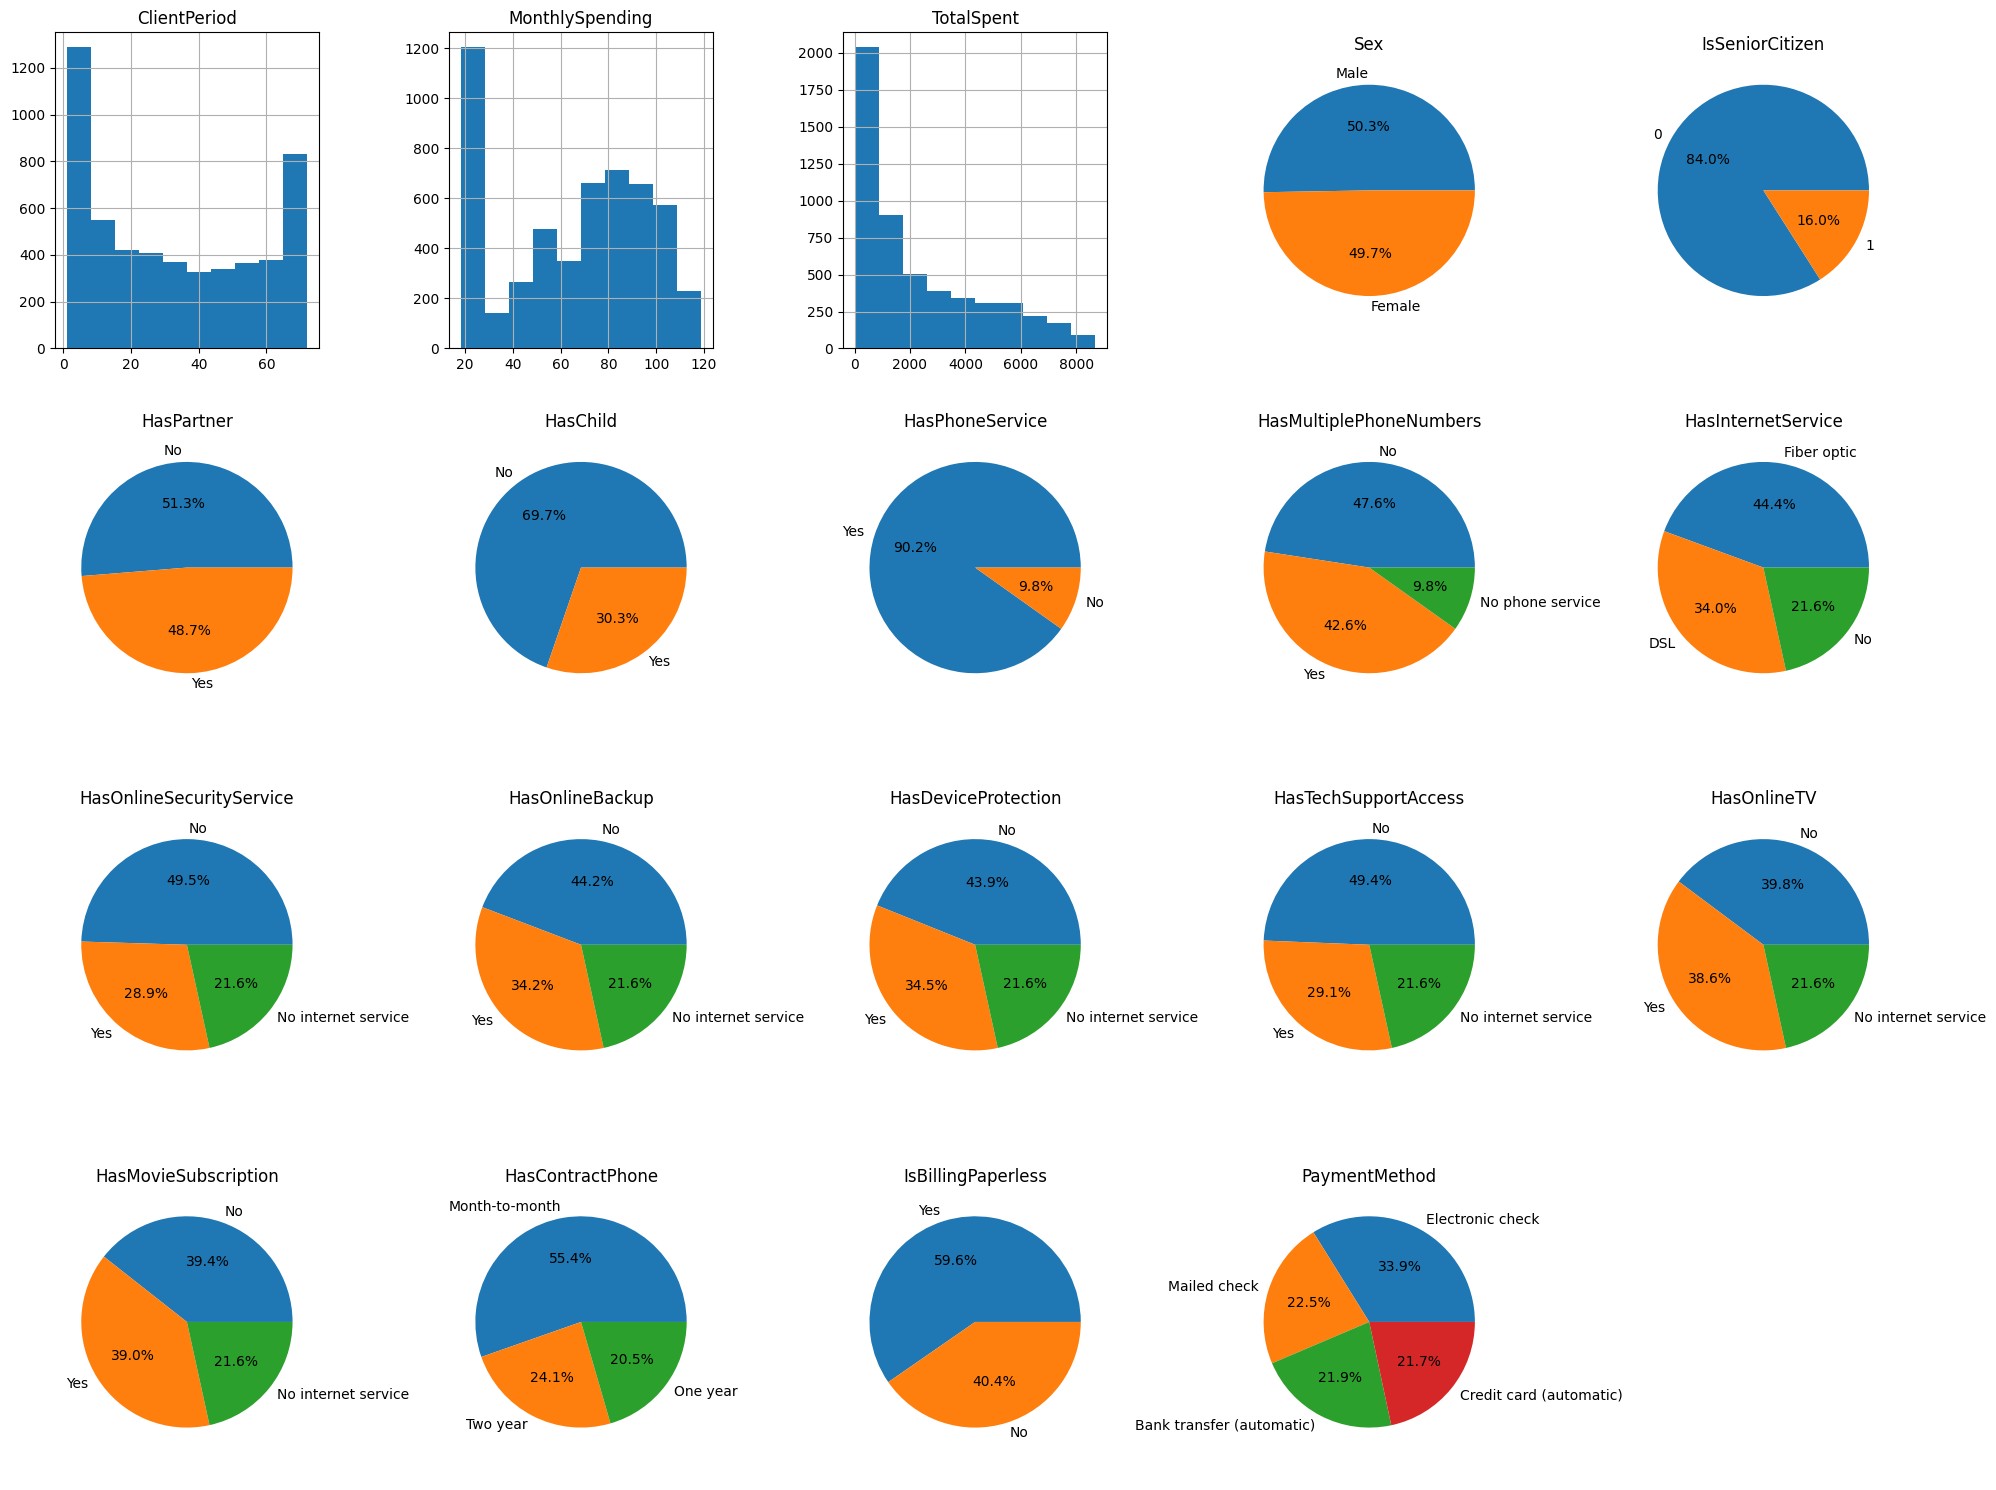

In [17]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 15))
axes = axes.flatten()

# Гистограммы по числовым признакам
for i, col in enumerate(num_cols):
  train[col].hist(ax=axes[i])
  axes[i].set_title(col)

# Круговые диаграммы по категориальным признакам
for i, col in enumerate(cat_cols, 3):
  value_counts = train[col].value_counts()
  axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
  axes[i].set_title(col)

axes[19].axis('off')

plt.tight_layout()
plt.show()

### 2.2
Задание: посмотреть на распределение целевой переменной и сказать, являются ли классы несбалансированными.


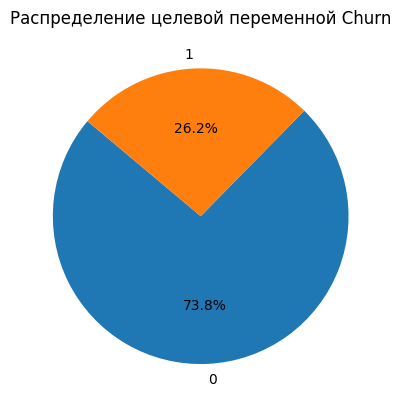

In [18]:
churn_counts = train['Churn'].value_counts()
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение целевой переменной Churn')
plt.show()

Классы немного несбалансированы: в датасете преобладает (составляет 3/4) класс 0.

### 2.3
Задание (по желанию): поиграть с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Полезно рассмотреть корреляционную матрицу для числовых признаков и целевой пееременной:

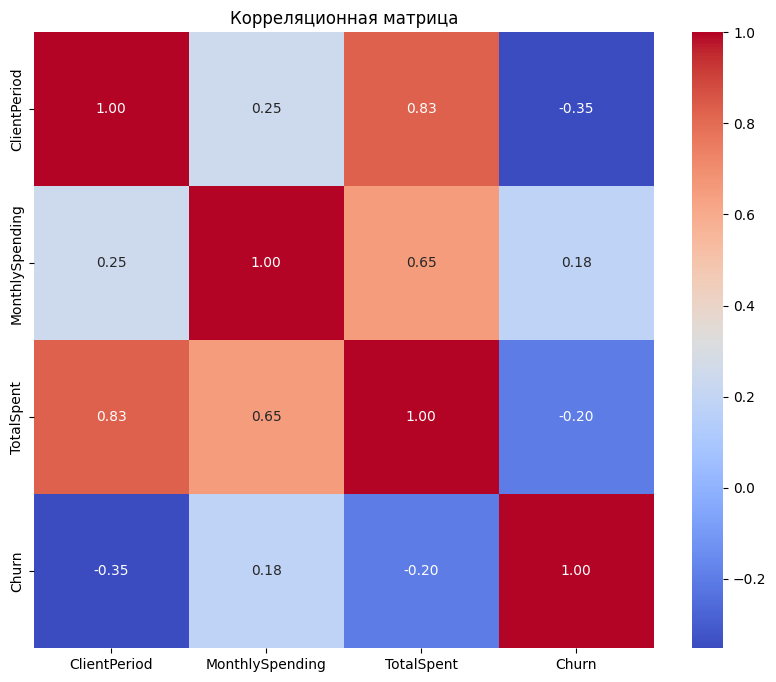

In [19]:
plt.figure(figsize=(10, 8))
corr = train[num_cols+['Churn']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

## 3) Применение линейных моделей

### 3.1

Задание: обработать данные для того, чтобы к ним можно было применить LogisticRegression (отнормировать числовые признаки, а категориальные закодировать с помощью one-hot-encoding).

In [20]:
scaler = StandardScaler()
scaler.fit(train[num_cols])
train[num_cols] = scaler.transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

In [21]:
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,0.919099,-1.506436,-0.557582,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,1.612060,-1.295997,-0.184763,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,-1.282072,0.362658,-0.976504,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,-0.018437,0.475334,0.122800,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,1.122911,1.666716,1.968909,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [22]:
train = pd.get_dummies(train, columns=cat_cols, drop_first=True) # один из столбцов избыточен - удаляем
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

In [23]:
# проверяем одинаковость набора признаков в обучающей и тестовой выборке
set(train.columns)-set(test.columns)

set()

In [24]:
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Churn,Sex_Male,IsSeniorCitizen_1,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_No phone service,...,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.919099,-1.506436,-0.557582,0,1,0,1,1,1,0,...,1,0,1,0,1,0,0,0,0,1
1,1.612060,-1.295997,-0.184763,0,1,0,1,0,1,0,...,1,0,1,0,0,1,0,1,0,0
2,-1.282072,0.362658,-0.976504,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
3,-0.018437,0.475334,0.122800,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1.122911,1.666716,1.968909,0,0,0,1,1,1,0,...,0,1,0,1,0,1,0,1,0,0


Логистическая регрессия с настройками по умолчанию:

In [25]:
X_train = train.drop('Churn', axis=1)
y_train = train['Churn']
X_test = test.drop('Churn', axis=1)
y_test = test['Churn']

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1] # предсказание вероятностей для тестового набора

roc_auc = roc_auc_score(y_test, y_pred_proba)
RA=[roc_auc]
print(f"ROC-AUC на тестовом наборе: {roc_auc}")

ROC-AUC на тестовом наборе: 0.8485405887660024


### 3.2
Задание: с помощью кроссвалидации или разделения на train/valid выборку протестировать разные значения гиперпараметра C и выбрать лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. *Если разделять на train/valid, то нужно использовать LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забыть передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C).*

In [26]:
model_cv = LogisticRegressionCV(Cs=[100, 10, 1, 0.1, 0.01, 0.001], cv=5, scoring='roc_auc', refit=True, max_iter=1000)
model_cv.fit(X_train, y_train)

best_C = model_cv.C_[0]
print(f"Лучшее значение C: {best_C}")

Лучшее значение C: 100.0


In [27]:
y_pred_proba = model_cv.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
RA.append(roc_auc)
print(f"ROC-AUC на тестовом наборе: {roc_auc}")

ROC-AUC на тестовом наборе: 0.8487878773240665


Как видно, качество незначительно улучшилось.

Примечание: в качестве более сложной задачи предлагают сделать следующее: преобразования данных и LogisticRegression соединить в один Pipeline с помощью make_pipeline, потом pipeline передать в GridSearchCV. Поскольку концептуально задача уже решена, просто напишу вариант кода, но не буду его запускать (єто ведь дополнительно):


```
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, roc_auc_score

pr = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols)
    ])

pipeline = make_pipeline(
    pr,
    LogisticRegression()
)

param_grid = {'C': [100, 10, 1, 0.1, 0.01, 0.001]}
scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=5, refit=True)
grid_search.fit(X, y)

print("Лучшее значение C:", grid_search.best_params_)
```



Таким образом, лучшее ROC-AUC которое удалось получить на данном этапе: 0.8488. Параметр: С=100.

## 4) Применение градиентного бустинга

Задание:
* Разделить выборку на train/valid. Протестировать catboost cо стандартными параметрами.
* Протестировать разные занчения параметроа количества деревьев и learning_rate'а и выбрать лучшую по метрике ROC-AUC комбинацию.

In [36]:
X_train_orig = train_orig.drop('Churn', axis=1)
y_train_orig = train_orig['Churn']
X_test_orig = test_orig.drop('Churn', axis=1)
y_test_orig = test_orig['Churn']

X_train2_orig, X_valid_orig, y_train2_orig, y_valid_orig = train_test_split(
    X_train_orig, y_train_orig, test_size=0.2, random_state=11)

In [37]:
X_train2_orig.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
4968,71,80.45,5662.25,Female,0,Yes,No,Yes,Yes,DSL,No,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic)
2206,9,94.40,857.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Electronic check
1092,30,64.50,1929.95,Male,0,No,Yes,Yes,No,DSL,No,Yes,Yes,No,Yes,No,One year,No,Credit card (automatic)
1718,37,62.80,2278.75,Male,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,No,No,Two year,Yes,Credit card (automatic)
731,42,67.70,2882.25,Female,0,No,No,Yes,No,DSL,Yes,Yes,No,Yes,No,Yes,One year,Yes,Mailed check


CatBoost со стандартными параметрами:

In [38]:
boosting_model = CatBoostClassifier(cat_features=cat_cols, verbose=False)
boosting_model.fit(X_train2_orig, y_train2_orig)

y_valid_predict = boosting_model.predict_proba(X_valid_orig)[:, 1]
roc_auc = roc_auc_score(y_valid_orig, y_valid_predict)
print(f"ROC-AUC на валидационном наборе: {roc_auc}")

ROC-AUC на валидационном наборе: 0.8421280669279907


In [39]:
# CatBoost с различными параметрами модели
parameters = [(100, 0.03), (100, 0.1), (100, 0.3),
              (200, 0.03), (200, 0.1), (200, 0.3),
              (300, 0.03), (300, 0.1), (300, 0.3)]
best_roc_auc = 0
best_params = None

for trees, lr in parameters:
    model = CatBoostClassifier(
        iterations=trees,
        learning_rate=lr,
        cat_features=cat_cols,
        verbose=False)
    model.fit(X_train2_orig, y_train2_orig)

    y_valid_predict = model.predict_proba(X_valid_orig)[:, 1]
    roc_auc = roc_auc_score(y_valid_orig, y_valid_predict)
    print(f"Количество деревьев: {trees}, Learning Rate: {lr}, ROC-AUC: {roc_auc}")

    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_params = (trees, lr)

print(f"Лучшие параметры: Количество деревьев: {best_params[0]}, Learning Rate: {best_params[1]}, ROC-AUC: {best_roc_auc}")

Количество деревьев: 100, Learning Rate: 0.03, ROC-AUC: 0.83684487514518
Количество деревьев: 100, Learning Rate: 0.1, ROC-AUC: 0.8431488639663184
Количество деревьев: 100, Learning Rate: 0.3, ROC-AUC: 0.8352705792682927
Количество деревьев: 200, Learning Rate: 0.03, ROC-AUC: 0.8408600101626015
Количество деревьев: 200, Learning Rate: 0.1, ROC-AUC: 0.8406331663763067
Количество деревьев: 200, Learning Rate: 0.3, ROC-AUC: 0.8266210256968641
Количество деревьев: 300, Learning Rate: 0.03, ROC-AUC: 0.8415609574622531
Количество деревьев: 300, Learning Rate: 0.1, ROC-AUC: 0.8345492160278745
Количество деревьев: 300, Learning Rate: 0.3, ROC-AUC: 0.8129196610046456
Лучшие параметры: Количество деревьев: 100, Learning Rate: 0.1, ROC-AUC: 0.8431488639663184


Теперь эту лучшую модель (в частности, эта модель лучше модели со стандартными настройками) применяем к тестовой выборке:

In [40]:
final_model = CatBoostClassifier(
    iterations=best_params[0],
    learning_rate=best_params[1],
    cat_features=cat_cols,
    verbose=False)

final_model.fit(X_train_orig, y_train_orig)
y_test_predict = final_model.predict_proba(X_test_orig)[:, 1]

# Расчет ROC-AUC для тестового набора
roc_auc_test = roc_auc_score(y_test_orig, y_test_predict)
RA.append(roc_auc_test)
print(f"ROC-AUC на тестовом наборе: {roc_auc_test}")

ROC-AUC на тестовом наборе: 0.8638688564306916


Таким образом, лучшее ROC-AUC которое удалось получить на данном этапе: 0.8639. При этом лучшие параметры: Количество деревьев: 100, Learning Rate: 0.1.

## 5) Сохранение результатов наилучшей модели:

Качество градиентного бустинга наилучшее:

In [49]:
list_models=['Логистическая регрессия','Логистическая регрессия','Градиентный бустинг']
comment=['со стандартными настройками','с подбором гиперпараметров','с подбором гиперпараметров']
pd.DataFrame({'Models': list_models, 'Comment':comment, 'ROC-AUC': RA})

,Models,Comment,ROC-AUC
0,Логистическая регрессия,со стандартными настройками,0.848541
1,Логистическая регрессия,с подбором гиперпараметров,0.848788
2,Градиентный бустинг,с подбором гиперпараметров,0.863869


In [51]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

y_test_proba = final_model.predict_proba(X_test)[:, 1]
submission['Churn'] = y_test_proba
submission.to_csv('./my_submission.csv', index=False)